# SMA Crossover Strategy

In [1]:
import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, time,datetime
%matplotlib inline

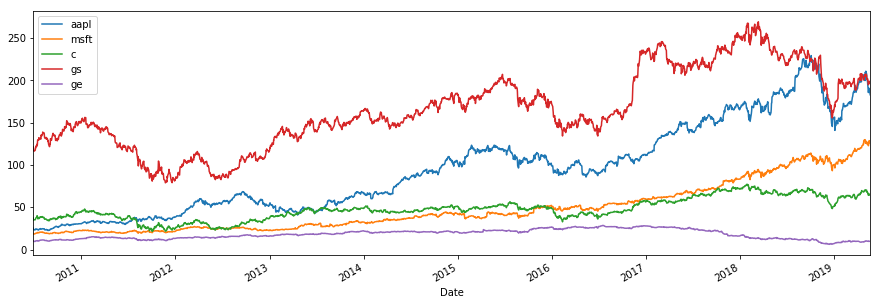

In [2]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-06-29', end='2019-05-20')
data.plot(figsize=(15, 5))

In [3]:
class WeighTarget(bt.Algo):
    
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

### 策略:長短期移動平均交叉法
#### 短期(20days)sma超過長期sma(240days)之交叉，表看漲→買進
#### 短期(20days)sma低於長期sma(240days)之交叉，表看跌→賣出

In [4]:
# ma cross backtest
def ma_cross(ticker, start='2010-06-29', end='2019-05-20',
             short_ma=20, long_ma=240, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start, end=end)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

In [5]:
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')
t3 = ma_cross('c', name='c_ma_cros')
t4 = ma_cross('gs', name='gs_ma_cross')
t5 = ma_cross('ge', name='ge_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data, t3.data, t4.data, t5.data)

# now we create the parent strategy
# we specify the children to be the two
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy, t3.strategy, t4.strategy, t5.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)
res.display()

s


C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
C:\Users\veryv\Anaconda3\lib\site-packages\ffn\core.py:1411: RuntimeWarning: divide by zero encountered in true_divide
  vol = np.divide(1. , np.std(returns,ddof=1) )


0% [############################# ] 100% | ETA: 00:00:02Stat                 s
-------------------  ----------
Start                2010-06-26
End                  2019-05-20
Risk-free rate       0.00%

Total Return         83.24%
Daily Sharpe         0.62
Daily Sortino        0.98
CAGR                 7.04%
Max Drawdown         -24.13%
Calmar Ratio         0.29

MTD                  -2.94%
3m                   -2.82%
6m                   -6.83%
YTD                  -16.21%
1Y                   6.44%
3Y (ann.)            17.88%
5Y (ann.)            8.11%
10Y (ann.)           7.04%
Since Incep. (ann.)  7.04%

Daily Sharpe         0.62
Daily Sortino        0.98
Daily Mean (ann.)    7.56%
Daily Vol (ann.)     12.23%
Daily Skew           -0.29
Daily Kurt           2.85
Best Day             4.17%
Worst Day            -4.19%

Monthly Sharpe       0.61
Monthly Sortino      0.98
Monthly Mean (ann.)  7.60%
Monthly Vol (ann.)   12.55%
Monthly Skew         -0.70
Monthly Kurt         2.34
Best Mon

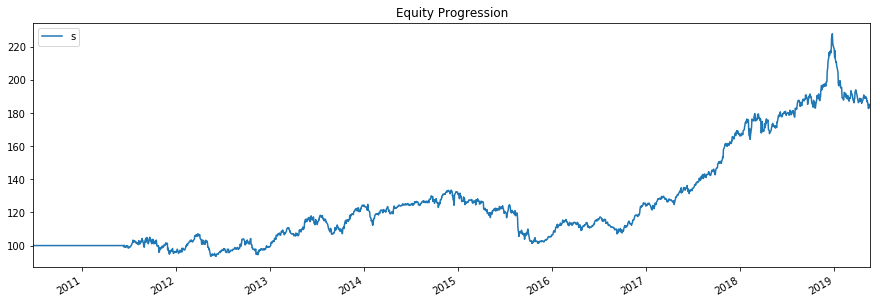

In [6]:
res.plot()

#  GDP weighted method

## AAPL

In [7]:
# get GDP data
path = 'C:/Users/veryv/Downloads/'
gdp = pd.read_csv(path + 'GDPC1.csv')

from datetime import datetime
gdp['Date'] = pd.to_datetime(gdp['Date'])

In [8]:
data = data.reset_index()
data.rename(columns={'index': 'Date'}, inplace=True)

In [9]:
new_data = pd.merge(data,gdp, on = 'Date', how='left')
new_data.head()

,Date,aapl,msft,c,gs,ge,GDPC1
0,2010-06-27,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-06-28,25.459557,19.440838,37.457748,121.497734,10.614961,NaN
2,2010-06-29,24.308521,18.641138,34.929348,118.919426,10.246974,NaN
3,2010-06-30,23.868223,18.401220,35.210285,116.705750,10.204516,NaN
4,2010-07-01,23.578798,18.521185,35.397579,116.590126,9.992217,15671.967


In [10]:
#　use near data fill gdp missing value
new_data = new_data.fillna(method='bfill')
new_data = new_data.fillna(method='ffill')
new_data = new_data.set_index('Date')
new_data.head()

,aapl,msft,c,gs,ge,GDPC1
Date,,,,,,
2010-06-27,25.459557,19.440838,37.457748,121.497734,10.614961,15671.967
2010-06-28,25.459557,19.440838,37.457748,121.497734,10.614961,15671.967
2010-06-29,24.308521,18.641138,34.929348,118.919426,10.246974,15671.967
2010-06-30,23.868223,18.401220,35.210285,116.705750,10.204516,15671.967
2010-07-01,23.578798,18.521185,35.397579,116.590126,9.992217,15671.967


In [11]:
#scale the index
from sklearn.preprocessing import MinMaxScaler
max_p = new_data.gs.max()
min_p = new_data['ge'].min()
scaler = MinMaxScaler(feature_range = (min_p, max_p))

x = new_data['GDPC1'].values.reshape(-1,1) #returns a numpy array
x_scaled = scaler.fit_transform(x)
new_data['GDPC1'] = x_scaled

### 策略:GDP長短期移動平均交叉法
#### 短期(20days)sma超過長期sma(240days)之交叉，表看漲→買進
#### 短期(20days)sma低於長期sma(240days)之交叉，表看跌→賣出

In [170]:
GDP = pd.DataFrame(new_data['GDPC1'])
GDP.loc['2010-06-27'] = np.NaN
GDP = GDP.dropna()

In [171]:
# GDP_ma_cross strategy
def GDP_cross(ticker, start='2010-06-28', end='2019-05-20',
             short_ma=20, long_ma=240, name='GDP_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start, end=end)
    short_sma = GDP.rolling(short_ma).mean()
    long_sma  = GDP.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0
    tw.loc['2010-06-27'] = np.NaN
    tw = tw.dropna()

    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])
    return bt.Backtest(s, data)
# ok now let's create a few backtests and gather the results.
# these will later gdpbecome our "synthetic securities"
t1 = GDP_cross(ticker = 'aapl', name = 'aapl_GDP_cross')
t2 = GDP_cross(ticker = 'msft', name = 'msft_GDP_cross')

In [162]:
data1 = new_data['GDPC1']
sma20 = data1.rolling(20).mean()
sma240 = data1.rolling(240).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma240.copy()
# set appropriate target weights
tw[sma20 > sma240] = 1.0
tw[sma20 <= sma240] = -1.0
tw[sma240.isnull()] = 0.0

#### 畫圖可知，GDP走勢貼近股價，故可以用來做買進賣出策略指標

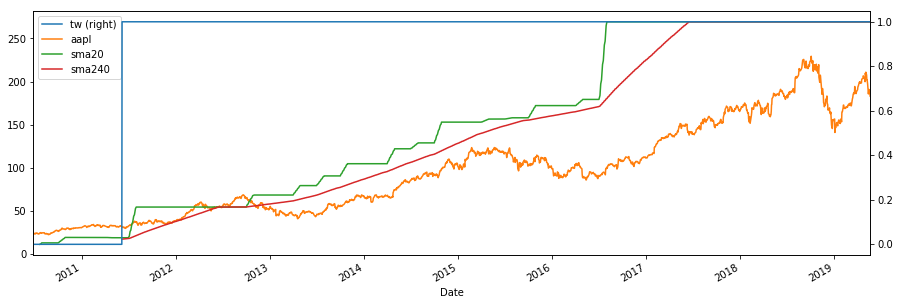

In [163]:
data1_1 = new_data['aapl']
tmp = bt.merge(tw, data1_1, sma20, sma240)
tmp.columns = ['tw', 'aapl', 'sma20', 'sma240']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

#### 依舊得到這個exception，有點不懂，我的weight形狀也跟上一部分的相同
debug 網站資訊也有點不明白:https://github.com/pmorissette/bt/issues/52

In [172]:
res = bt.run(t1, t2)

aapl_GDP_cross
0% [#                             ] 100% | ETA: 00:00:06

C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


0% [###                           ] 100% | ETA: 00:00:03

Exception: Cannot allocate capital to GDPC1 because price is 0 as of 2011-06-08 00:00:00

## Msft

In [173]:
data2 = new_data['GDPC1']
sma20 = data2.rolling(20).mean()
sma240 = data2.rolling(240).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma240.copy()
# set appropriate target weights
tw[sma20 > sma240] = 1.0
tw[sma20 <= sma240] = -1.0
tw[sma240.isnull()] = 0.0

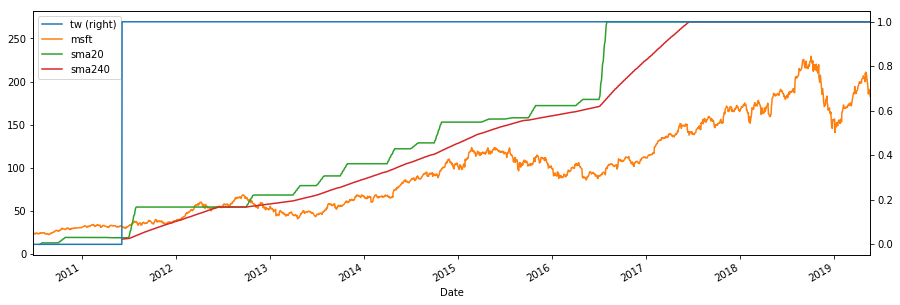

In [174]:
data2_1 = new_data['msft']
tmp = bt.merge(tw, data1_1, sma20, sma240)
tmp.columns = ['tw', 'msft', 'sma20', 'sma240']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [340]:
tw = pd.DataFrame(tw)

#### 這邊也是無法跑

In [176]:
data2_1 = bt.get('msft', start='2010-06-29', end = '2019-05-20')
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data2_1)
res = bt.run(t)

ma_cross


C:\Users\veryv\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


AttributeError: 'numpy.float64' object has no attribute 'dropna'